# Implémentez un modèle de scoring par Frejus IBATTA


Data Science - Projet 7 - Juillet 2023

Modélisation sur Google collab

Etude réalisée en langage Python

*Data source* : https://www.kaggle.com/c/home-credit-default-risk/data

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

## Code de la modélisation
Dans le Notebook Jupyter nous avons vu l'exploration, ainsi que le prétraitement des données. Ici nous utiliserons un GPU pour effectuer les modélisations Catboost, LightGBM & XGBoost. Ici nous sommes en Google Colab PRO, donc l'accès au GPU est illimité… _L'offre free ne permet pas de mener à bien ce projet, les limites ont rapidement étaient atteintes pour effectuer les différents tests._


In [1]:
#Test de l'activation du GPU
#Si le GPU est activé, il donnera la sortie suivante - '/ device: GPU: 0 '
import tensorflow as tf
tf.test.gpu_device_name ()

'/device:GPU:0'

In [2]:
#Appareils utilisés lors de l'exécution du notebook dans le cloud
from tensorflow.python.client import device_lib
device_lib.list_local_devices ()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18112274979720474439
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40129593344
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17840997684414038315
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [3]:
#Vérification de la RAM
!cat /proc/meminfo

MemTotal:       87535920 kB
MemFree:        79255792 kB
MemAvailable:   84822376 kB
Buffers:          140128 kB
Cached:          6093256 kB
SwapCached:            0 kB
Active:          1255008 kB
Inactive:        6322144 kB
Active(anon):       2972 kB
Inactive(anon):  1354428 kB
Active(file):    1252036 kB
Inactive(file):  4967716 kB
Unevictable:          12 kB
Mlocked:              12 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              2412 kB
Writeback:             0 kB
AnonPages:       1333948 kB
Mapped:           825316 kB
Shmem:             13612 kB
KReclaimable:     187724 kB
Slab:             275012 kB
SReclaimable:     187724 kB
SUnreclaim:        87288 kB
KernelStack:        9504 kB
PageTables:        12644 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    43767960 kB
Committed_AS:    5783384 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       98928 kB
VmallocChunk:          0 kB
Percpu:          

---

In [4]:
!pip install catboost

In [5]:
!rm -rf LightGBM

In [6]:
!apt-get install -y libboost-all-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-all-dev is already the newest version (1.71.0.0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [7]:
!git clone --recursive https://github.com/microsoft/LightGBM
%cd LightGBM
!git checkout tags/v3.3.3
!mkdir -p build

Cloning into 'LightGBM'...
remote: Enumerating objects: 29547, done.
remote: Counting objects: 100% (5186/5186), done.
remote: Compressing objects: 100% (384/384), done.
remote: Total 29547 (delta 4950), reused 4888 (delta 4798), pack-reused 24361
Receiving objects: 100% (29547/29547), 20.77 MiB | 18.52 MiB/s, done.
Resolving deltas: 100% (21996/21996), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remot

In [8]:
!cd /content/LightGBM && cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/


CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_3_0
-- Looking for CL_VERSION_3_0 - found
-- Found OpenCL: /usr/local/cuda/lib64/libOpenCL.so (found version

In [9]:
ls

build/                  CMakeLists.txt      helpers/         R-package/
build-cran-package.sh*  CODE_OF_CONDUCT.md  include/         src/
build_r.R               CONTRIBUTING.md     LICENSE          swig/
cmake/                  docker/             Makefile         tests/
CMakeCache.txt          docs/               pmml/            VERSION.txt
CMakeFiles/             examples/           python-package/  windows/
cmake_install.cmake     external_libs/      README.md


In [10]:
!ls /content/LightGBM/python-package

lightgbm  MANIFEST.in  README.rst  setup.py


In [11]:
!cd /content/LightGBM && make -j$(nproc)

[  1%] Building CXX object CMakeFiles/lightgbm.dir/src/main.cpp.o
[  2%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/boosting.cpp.o
[  4%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/gbdt.cpp.o
[  5%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/boosting.cpp.o
[  8%] Building CXX object CMakeFiles/lightgbm.dir/src/application/application.cpp.o
[  8%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/gbdt_model_text.cpp.o
[ 10%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/gbdt_prediction.cpp.o
[ 11%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/prediction_early_stop.cpp.o
[ 13%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/gbdt.cpp.o
[ 14%] Building CXX object CMakeFiles/_lightgbm.dir/src/io/bin.cpp.o
[ 15%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/gbdt_model_text.cpp.o
[ 17%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/gbdt_prediction.cpp.o
[ 18%] Building CXX object CMak

In [12]:
!cd /content/LightGBM/python-package && python3 setup.py install --precompile --gpu

INFO:root:running install
/content/LightGBM/python-package/setup.py:220: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  install.initialize_options(self)
INFO:root:running build
INFO:root:running build_py
INFO:root:creating build
INFO:root:creating build/lib
INFO:root:creating build/lib/lightgbm
INFO:root:copying lightgbm/callback.py -> build/lib/lightgbm
INFO:root:copying lightgbm/basic.py -> build/lib/lightgbm
INFO:root:copying lightgbm/engine.py -> build/lib/lightgbm
INFO:root:copying lightgbm/compat.py -> build/lib/lightgbm
INFO:root:copying li

In [13]:
!mkdir -p /etc/OpenCL/vendors
!echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [14]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [15]:
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [18]:
# Télécharger des fichiers depuis Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Deuxième solution >>> importer des fichiers depuis votre ordinateur
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('Vous avez importé le fichier "{name}" qui a une taille de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Mounted at /content/gdrive


In [19]:
z = ZipFile("/content/gdrive/My Drive/Colab Notebooks/p7_00_data/data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 309)

In [20]:
TARGET = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certains clients, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances=None):
    '''Cette fonction permet de créer une représentation graphique d'une matrice de confusion
    sklearn à l'aide d'une heatmap de la bibliothèque Seaborn, ainsi qu'une courbe ROC.'''

    fig = plt.figure(figsize=(12, 6))

    # Matrice de confusion
    plt.subplot(121)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Matrice de confusion')

    # Courbe ROC
    plt.subplot(122)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=2, label='Courbe ROC (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend()

    # Plot des importances des caractéristiques si disponible
    if feature_importances:
        plt.figure(figsize=(12, 4))
        feature_names = feature_importances.index
        feature_importance_values = feature_importances.values
        sns.barplot(x=feature_importance_values, y=feature_names, color='orange')
        plt.xlabel('Importance des caractéristiques')
        plt.ylabel('Caractéristiques')
        plt.title('Importance des caractéristiques')

    plt.tight_layout()
    plt.show()


In [25]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: user 12.1 s, sys: 8.56 s, total: 20.6 s
Wall time: 2.05 s


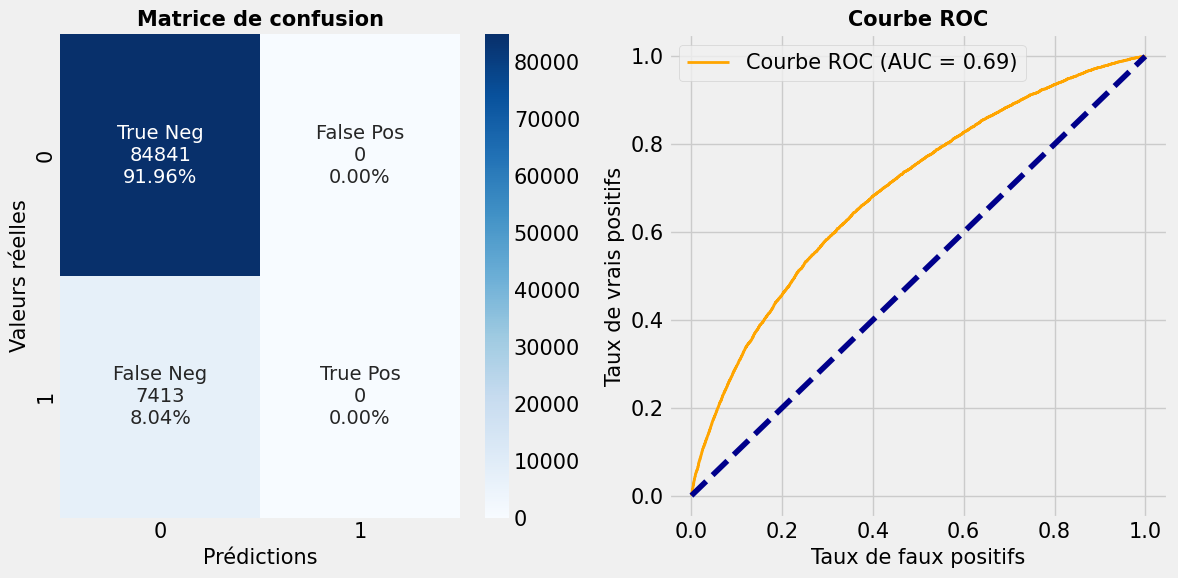

In [26]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



In [27]:
print("Label 1, Avant utilisation SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Avant utilisation SMOTE: {} ".format(sum(y_train==0)))

Label 1, Avant utilisation SMOTE: 17412 
Label 0, Avant utilisation SMOTE: 197845 


In [28]:
%%time

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

CPU times: user 9.98 s, sys: 657 ms, total: 10.6 s
Wall time: 2.39 s


In [29]:
print("Label 1, Après utilisation SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, Après utilisation SMOTE: {}".format(sum(y_train_res==0)))

Label 1, Après utilisation SMOTE: 197845
Label 0, Après utilisation SMOTE: 197845


In [30]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7196
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: user 50.1 s, sys: 25.9 s, total: 1min 15s
Wall time: 6.97 s


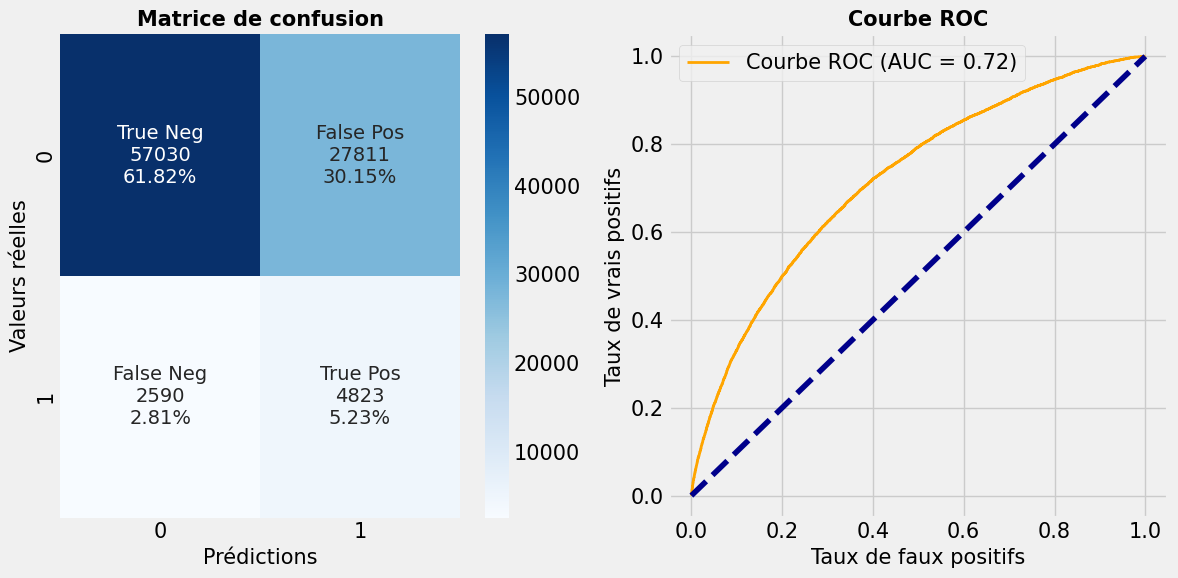

In [31]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…

### **Gradient Boosting**

In [32]:
#Modèles prédictifs
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device="gpu"),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')]


La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [33]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }

    return output

In [34]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

# Initialisation des données des listes
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

CPU times: user 1min 58s, sys: 4.97 s, total: 2min 2s
Wall time: 1min 8s


In [35]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.774617,0.919971,0.533937,0.031836,0.060089,3.98416
0,CatBoostClassifier,0.773559,0.920144,0.5625,0.027924,0.053207,61.577138
2,XGBClassifier,0.76713,0.918681,0.449944,0.053959,0.096362,3.27655


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [36]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

# Initialisation des données des listes
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

CPU times: user 3min 20s, sys: 6.76 s, total: 3min 27s
Wall time: 1min 33s


In [37]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.760234,0.919559,0.489848,0.026035,0.049443,80.103046
2,XGBClassifier,0.753406,0.91802,0.420551,0.053555,0.09501,4.31129
1,LGBMClassifier,0.752409,0.918865,0.398876,0.019156,0.036556,8.643158


XGBClassifier est le "plus performant" selon le couple métrique/temps.

### **Feature Selection - Recursive Feature Elimination**
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``XGBClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [38]:
%%time
start = time.time()

# Définir les paramètres du XGBClassifier
xgb_params = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',  # Utiliser le GPU pour l'entraînement
    'predictor': 'gpu_predictor'  # Utiliser le GPU pour les prédictions
}

# Créer et entraîner le RFECV avec XGBClassifier en utilisant le GPU
start = time.time()
rfecv = RFECV(estimator=XGBClassifier(**xgb_params),
              step=5,
              cv=StratifiedKFold(5),
              scoring='roc_auc',
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Temps écoulé : {}'.format(time.time()-start))

Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

In [39]:
print("Nombre optimal de features : %d" % rfecv.n_features_)
print("Features sélectionnés: %s" % rfecv.support_[:20])
print("Ranking ou classement des features : %s" % rfecv.ranking_[:20])

Nombre optimal de features : 154
Features sélectionnés: [ True  True False False  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Ranking ou classement des features : [ 1  1 10  6  1  1  1  1  1  1  1  1  1  1 21 11  1 22  7 10]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [40]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

154
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE', 'PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY', 'PREV_APPL_MEAN_AMT_GOODS_PRICE'

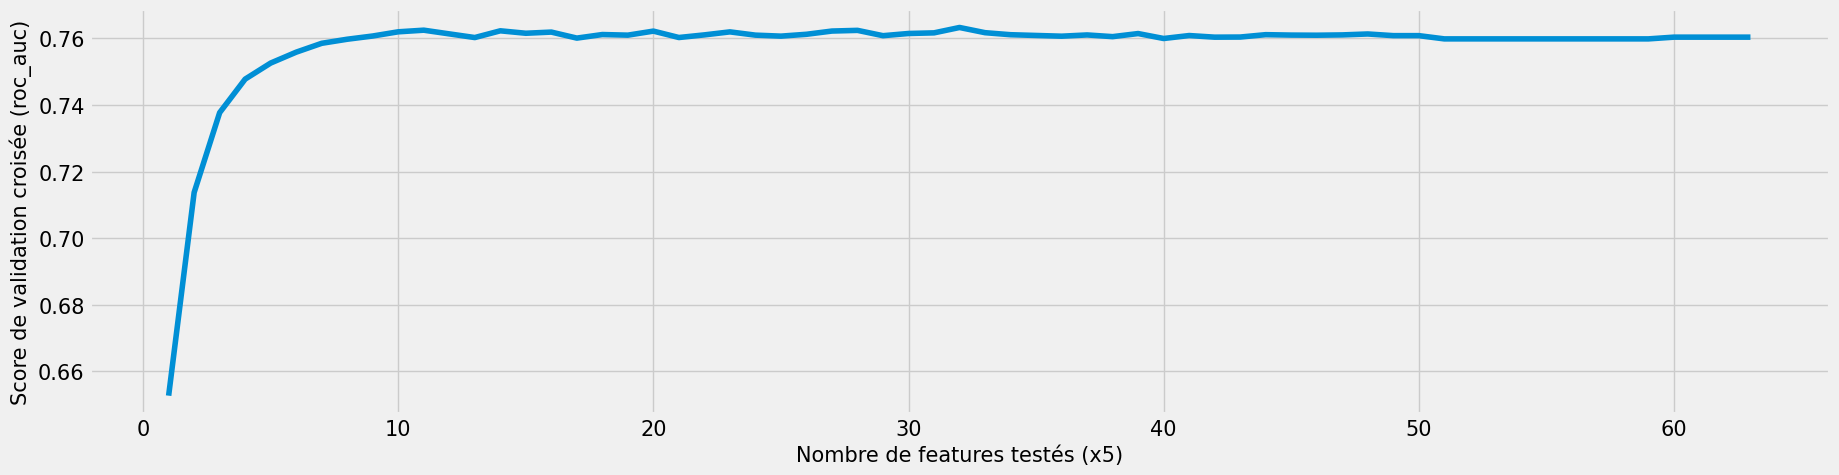

In [41]:
#Traçons le nombre de features en fonction des scores de validation croisée

step = 5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Nombre de features testés (x%d)' % step)
plt.ylabel('Score de validation croisée (roc_auc)')
plt.show()


RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [42]:
"#X_data est très important pour mettre en œuvre le graphique d'importance des fonctionnalités (features)..."
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 154)

Il est nécessaire de sauvegarder le dataset ``X_data`` de manière à pouvoir le réutiliser facilement…

In [43]:
#operation de fusion avec TARGET
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [44]:
X_data.shape

(307511, 155)

In [45]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/X_data.zip', index=True, compression=compression_opts)

CPU times: user 1min 9s, sys: 535 ms, total: 1min 10s
Wall time: 1min 10s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 149 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [46]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/X_sample.zip', index=True, compression=compression_opts)

CPU times: user 7.04 s, sys: 147 ms, total: 7.18 s
Wall time: 7.18 s


In [47]:
%%time
X_data.sample(10000).to_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/X_sample.csv', index=True)

CPU times: user 1.52 s, sys: 16.3 ms, total: 1.54 s
Wall time: 1.6 s


In [48]:
#Transformation de data avec rfecv
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [49]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methodes
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }

    return output

In [50]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

CPU times: user 55.7 s, sys: 4.17 s, total: 59.8 s
Wall time: 13 s


In [51]:
#Performance des modèles
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.774481,0.919993,0.537209,0.031161,0.058906,3.641717
0,CatBoostClassifier,0.77391,0.920155,0.56168,0.028868,0.054914,6.867785
2,XGBClassifier,0.766735,0.919505,0.492912,0.060974,0.108523,2.48212


In [52]:
###Rappel avant la selection de features
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.774617,0.919971,0.533937,0.031836,0.060089,3.98416
0,CatBoostClassifier,0.773559,0.920144,0.5625,0.027924,0.053207,61.577138
2,XGBClassifier,0.76713,0.918681,0.449944,0.053959,0.096362,3.27655


**LGBMClassifier est le modèle le plus performant selon le couple AUC score/Time.** CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

----
Dans la dernière partie de l'étude on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative.

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive.

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall :
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}\
On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.



In [53]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''Fonction de Scoring'''
    tp, tn, fp, fn = predictions_success

    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))

    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [54]:
def custom_score(y_true, y_pred, beta=3):
    '''Fonction pour pénaliser les faux positifs et les faux négatifs...'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)  # Calcul du rappel
    precision = tp / (tp + fp)  # Calcul de la précision
    fscore = (1 + beta) * ((tp / ((1 + beta) * tp + beta * fn + fp)))  # Calcul du score F-beta

    return 1 - fscore

In [55]:
def cost_false(model, y_true, X_true):
    '''Fonction de coût qui analyse les erreurs de prédiction False Pos. et False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1] / np.sum(cm)  # Calcul du taux de faux positifs
    FN = cm[1][0] / np.sum(cm)  # Calcul du taux de faux négatifs

    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))

    return FP, FN

### **Hyperparameters tunning - Hyperopt et AUC score**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.


Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [56]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [57]:
#Parametre space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [58]:
def objective(params, eval_metric='custom_score'):
    # Fonction objectif à minimiser.
    # Hyperopt cherchera à minimiser la perte retournée par cette fonction.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device': 'gpu'
    }

    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)

    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()
    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    loss = 1 - score

    return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [59]:
import hyperopt

In [60]:
%%time
import random
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

seed = 1
random.seed(seed)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=Trials())


100%|██████████| 30/30 [15:44<00:00, 31.49s/trial, best loss: 0.9769451593743813]
CPU times: user 2h 37min 55s, sys: 37.6 s, total: 2h 38min 33s
Wall time: 15min 44s


In [61]:
%%time
lgbm = LGBMClassifier( # Crée un nouveau modèle en utilisant les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree=best['colsample_bytree'],
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_lambda=best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train) # Ajuste le modèle sur les données d'entraînement
pickle.dump(lgbm, open("/content/gdrive/My Drive/Colab Notebooks/p7_00_data/p7_00_models/LGBMClassifier.pkl", "wb")) # Sauvegarde le modèle dans un fichier

CPU times: user 1min 18s, sys: 317 ms, total: 1min 18s
Wall time: 7.51 s


In [62]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.780175


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''Cette fonction génère un graphique clair d'une matrice de confusion
    sklearn en utilisant une visualisation de heatmap Seaborn + la courbe ROC.'''
    fig = plt.figure(figsize=(20, 15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['Vrai Nég', 'Faux Pos', 'Faux Nég', 'Vrai Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend()

    if feature_importances:
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

        features = []
        for i in range(20):
            features.append(X_data.columns[indices[i]])  # Après la sélection RFECV > X_data créé

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Importance des caractéristiques')
        plt.xticks(rotation=90)

    plt.show()


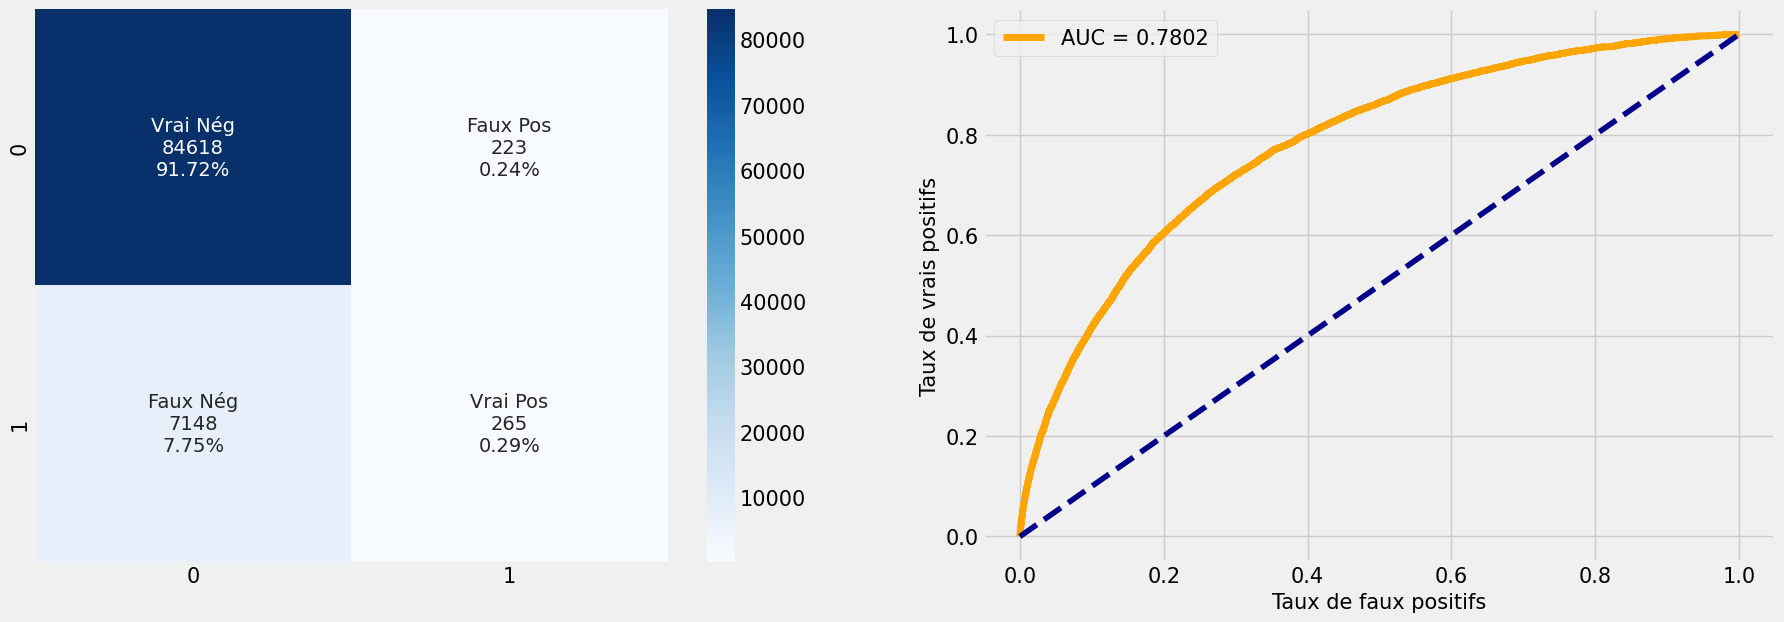

In [64]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=False)

In [65]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.24%
False Neg: 7.75%


(0.0024172393608949206, 0.07748173520931342)

In [66]:
#On vérifie la liste features importance
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]])

['CREDIT_TERM', 851]
['EXT_SOURCE_1', 687]
['EXT_SOURCE_3', 599]
['DAYS_BIRTH', 589]
['EXT_SOURCE_2', 539]
['PREV_APPL_MEAN_CNT_PAYMENT', 429]
['AMT_ANNUITY', 410]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 355]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 351]
['DAYS_ID_PUBLISH', 338]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 329]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 325]
['AMT_GOODS_PRICE', 294]
['DAYS_REGISTRATION', 285]
['ANNUITY_INCOME_PERCENT', 282]
['DAYS_EMPLOYED', 280]
['AMT_CREDIT', 268]
['PREV_BUR_MEAN_DAYS_CREDIT', 267]
['PREV_APPL_MEAN_AMT_ANNUITY', 255]
['DAYS_EMPLOYED_PERCENT', 249]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 246]
['DAYS_LAST_PHONE_CHANGE', 245]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 232]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 230]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 221]
['PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 211]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 206]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 201]
['PREV_APPL_MEAN_DAYS_LAST_DUE

In [67]:
def objective(params, eval_metric='roc_auc'):
    # Fonction objectif à minimiser.
    # Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.

    # Paramètres à optimiser
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device': 'gpu'
    }

    # Création du modèle LGBMClassifier avec les paramètres optimisés
    model = LGBMClassifier(**params)

    # Validation croisée avec StratifiedKFold
    cv = StratifiedKFold(5)

    # Calcul du score en fonction de la métrique d'évaluation
    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()
    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    # Calcul de la perte à minimiser (1 - score)
    loss = 1 - score

    return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [75]:
%%time
import random
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

seed = 1
random.seed(seed)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=Trials())


100%|██████████| 30/30 [14:24<00:00, 28.82s/trial, best loss: 0.22441248574861772]
CPU times: user 2h 23min 8s, sys: 35.7 s, total: 2h 23min 43s
Wall time: 14min 24s


In [69]:
%%time
lgbm = LGBMClassifier( # Créer un nouveau modèle en utilisant les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree=best['colsample_bytree'],
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_lambda=best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train) # Ajuster le modèle sur les données d'entraînement
#pickle.dump(lgbm, open("/content/gdrive/My Drive/Colab Notebooks/p7_00_models/LGBMClassifier.pkl", "wb")) # Sauvegarder le modèle dans un fichier


CPU times: user 2min 35s, sys: 392 ms, total: 2min 36s
Wall time: 14.6 s


LGBMClassifier(colsample_bytree=0.7494167361685209, device='gpu',
               learning_rate=0.029705083441789563, max_depth=7,
               n_estimators=600, reg_lambda=5.382612746064941,
               subsample=0.8070991023967327)

In [70]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.780173


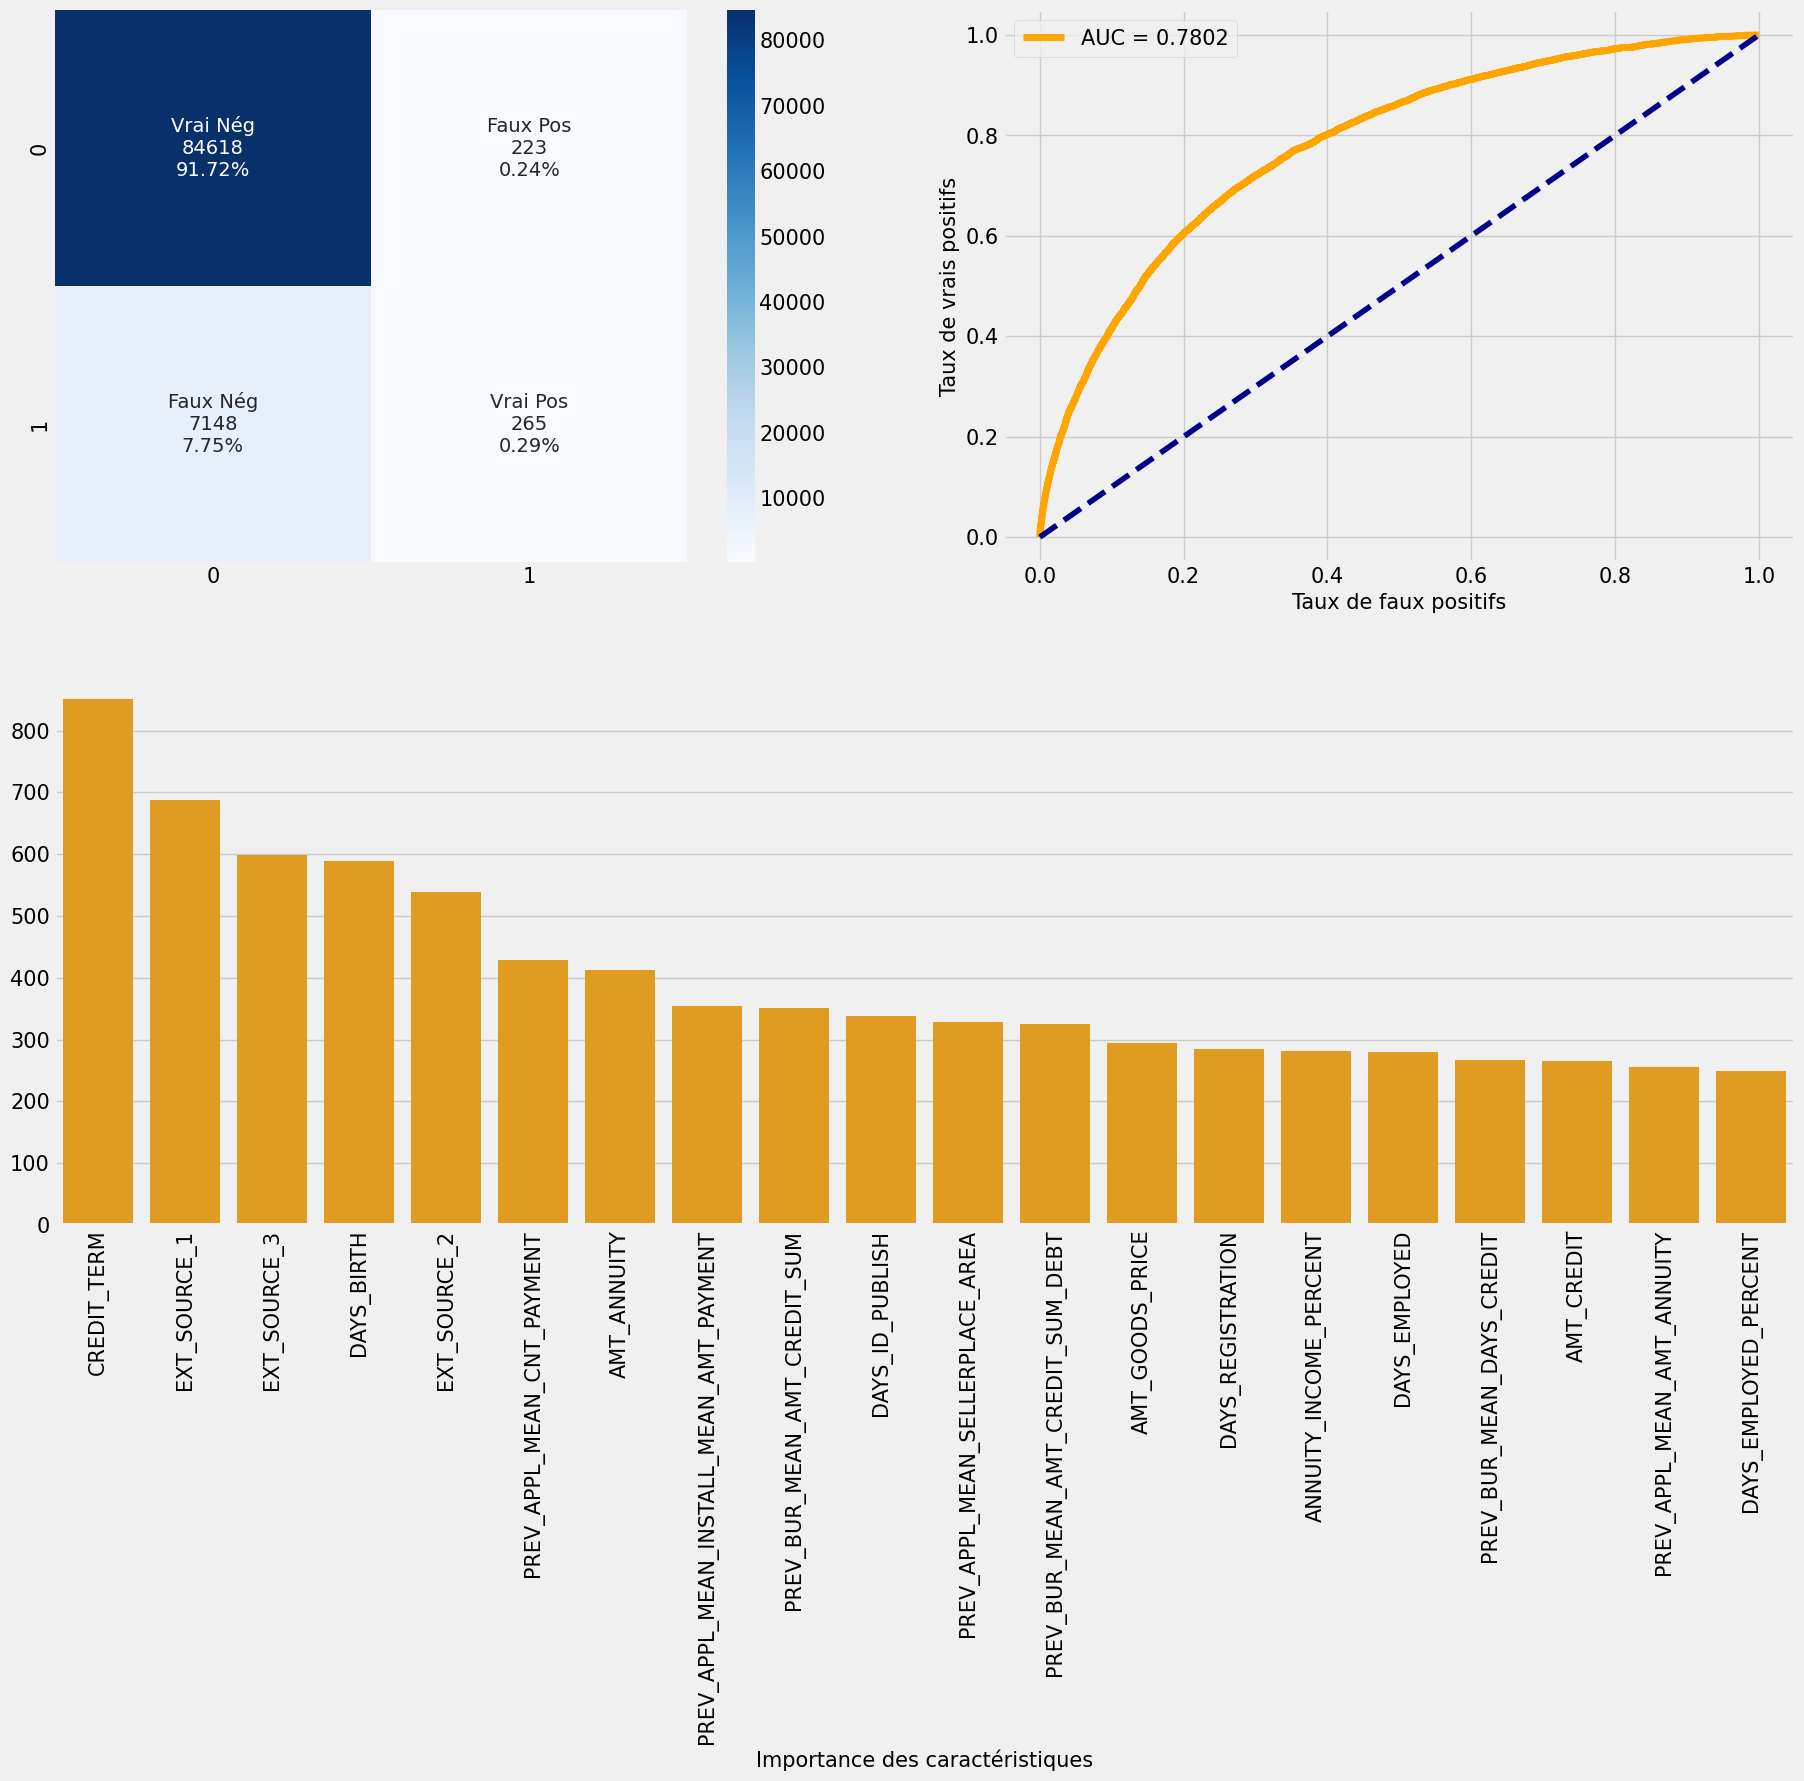

In [71]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [72]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.24%
False Neg: 7.75%


(0.0024172393608949206, 0.07748173520931342)

In [73]:
#Check list features importance
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]])

['CREDIT_TERM', 851]
['EXT_SOURCE_1', 687]
['EXT_SOURCE_3', 599]
['DAYS_BIRTH', 589]
['EXT_SOURCE_2', 539]
['PREV_APPL_MEAN_CNT_PAYMENT', 429]
['AMT_ANNUITY', 412]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 355]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 351]
['DAYS_ID_PUBLISH', 338]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 329]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 325]
['AMT_GOODS_PRICE', 294]
['DAYS_REGISTRATION', 285]
['ANNUITY_INCOME_PERCENT', 282]
['DAYS_EMPLOYED', 280]
['PREV_BUR_MEAN_DAYS_CREDIT', 267]
['AMT_CREDIT', 266]
['PREV_APPL_MEAN_AMT_ANNUITY', 255]
['DAYS_EMPLOYED_PERCENT', 249]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 246]
['DAYS_LAST_PHONE_CHANGE', 245]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 232]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 230]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 221]
['PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 211]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 206]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 201]
['PREV_APPL_MEAN_DAYS_LAST_DUE

**Conclusion**\
Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 149. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter chères à l'entreprise. Pour conclure ce résultat indique les taux de faux positifs (False Pos) et de faux négatifs (False Neg) obtenus en utilisant le modèle LGBMClassifier sur l'ensemble de test (y_test, X_test_selected).

- Le taux de faux positifs est de 0.24%, ce qui signifie que 0.24% des échantillons qui sont réellement négatifs ont été classés à tort comme positifs par le modèle.

- Le taux de faux négatifs est de 7.77%, ce qui signifie que 7.77% des échantillons qui sont réellement positifs ont été classés à tort comme négatifs par le modèle.

Ces mesures permettent d'évaluer la performance du modèle en termes d'erreurs de classification. Un taux de faux positifs plus bas et un taux de faux négatifs plus bas indiquent une meilleure performance du modèle.